In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

C:\Users\user\AppData\Local\Temp\ipykernel_24504\247537818.py:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [7]:
# Load dataset
df = pd.read_csv('CSV_files/M777_Howitzer_Artillery.csv')

In [8]:
# Features (X) and Target (y)
X = df[['Distance_to_Target_m','Initial_Velocity_m_s', 'Wind_Speed_m_s', 'Wind_Direction_deg']]
y = df['Firing_Angle_deg']

In [9]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
#hyperparameter tunning
def build_model(hp):
    model = Sequential()
    # Input layer with first hidden layer
    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=512, step=64),
                    activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Additional hidden layers with units and dropout rate
    for i in range(2, 4):  # 2 additional hidden layers
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Compile the model with different learning rates
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', 
                                                                             values=[1e-2, 1e-3, 1e-4, 1e-5])),
                  loss=tf.keras.losses.Huber(),
                  metrics=['mae'])
    return model

In [11]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,  # Number of evaluations per trial to stabilize results
    directory='tuning_dir',
    project_name='hyperparam_tuning'
)

# Perform hyperparameter search
tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, batch_size=64)

Trial 20 Complete [00h 04m 00s]
val_mae: 1.5837942361831665

Best val_mae So Far: 1.562815546989441
Total elapsed time: 01h 12m 23s
Best Hyperparameters:
Units (layer 1): 320
Dropout rate (layer 1): 0.4
Learning rate: 0.0001


In [28]:
# Get the best hyperparameters and print them
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Units (layer 1)       : {best_hps.get('units_1')}")
print(f"Dropout rate (layer 1): {best_hps.get('dropout_1')}")
print(f"Units (layer 2)       : {best_hps.get('units_2')}")
print(f"Dropout rate (layer 2): {best_hps.get('dropout_2')}")
print(f"Units (layer 3)       : {best_hps.get('units_3')}")
print(f"Dropout rate (layer 3): {best_hps.get('dropout_3')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
Units (layer 1)       : 320
Dropout rate (layer 1): 0.4
Units (layer 2)       : 256
Dropout rate (layer 2): 0.5
Units (layer 3)       : 256
Dropout rate (layer 3): 0.1
Learning rate: 0.0001


In [14]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, batch_size=64)

Epoch 1/100


d:\PROGRAMS\MAIN_Softwares\PYTHON\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 56.3307 - mae: 56.8283 - val_loss: 10.3616 - val_mae: 10.8513
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 11.9308 - mae: 12.4218 - val_loss: 8.1720 - val_mae: 8.6593
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.8989 - mae: 10.3888 - val_loss: 5.7959 - val_mae: 6.2771
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.9449 - mae: 8.4328 - val_loss: 3.7887 - val_mae: 4.2640
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.6726 - mae: 7.1595 - val_loss: 2.6158 - val_mae: 3.0817
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.0182 - mae: 6.5013 - val_loss: 1.9675 - val_mae: 2.4245
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.8384 - mae: 6.3221 - val_loss: 1.7783 - val_mae: 2.2325
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.6371 - mae: 6.1198 - val_loss: 1.6695 - val_mae: 2.1236
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step 

In [17]:
best_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 320)            │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 449,477 (1.71 MB)

 Trainable params: 149,825 (585.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 299,652 (1.14 MB)

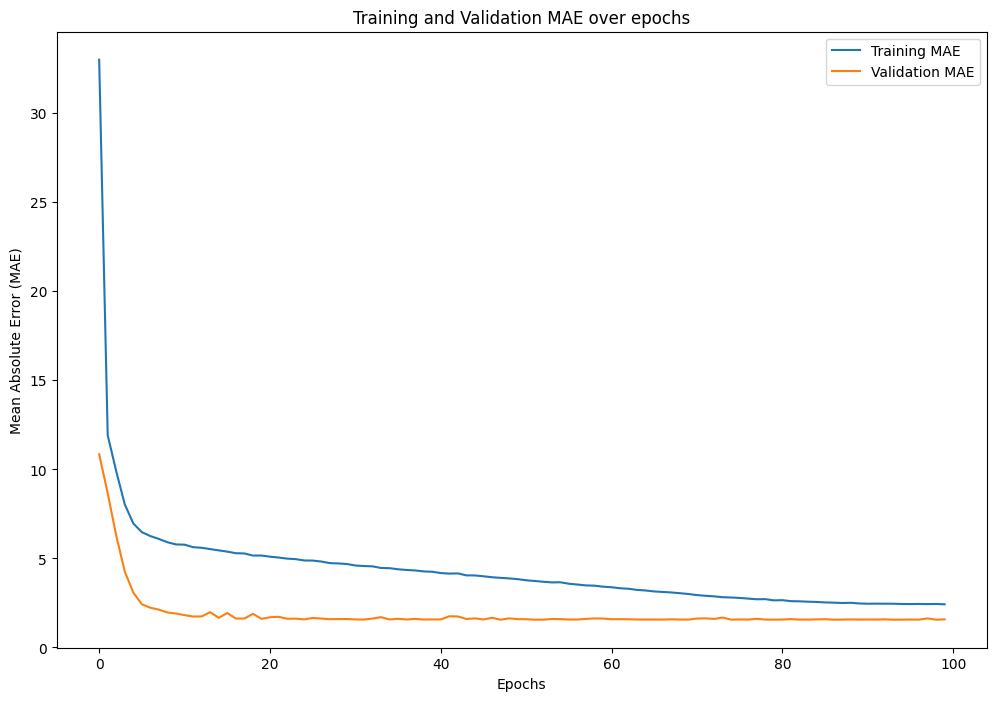

In [16]:
# Plot the tuning results for MAE over epochs
plt.figure(figsize=(12, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE over epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()

In [18]:
# Evaluate the model
test_loss = best_model.evaluate(X_test_scaled, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1749 - mae: 1.6108


In [19]:
# Make predictions
y_pred = best_model.predict(X_test_scaled)
y_pred=y_pred.ravel()
y_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([85.598625, 78.99294 , 79.08995 , ..., 78.81478 , 80.70179 ,
       87.92241 ], dtype=float32)

In [20]:
# Compute MSE, RMSE, MAE, and R-Squared
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Custom accuracy function
def percentage_accuracy(y_true, y_pred, threshold=5):
    percentage_error = np.abs((y_true - y_pred) / y_true) * 100
    accurate_predictions = np.sum(percentage_error < threshold)
    accuracy = (accurate_predictions / len(y_true)) * 100
    return accuracy

# Calculate custom percentage accuracy (within 5% tolerance)
accuracy = percentage_accuracy(y_test, y_pred, threshold=5)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-Squared: {r2}")
print(f"Custom Accuracy (within 5% error): {accuracy}%")

Mean Squared Error (MSE): 3.939025995022389
Root Mean Squared Error (RMSE): 1.9846979606535573
Mean Absolute Error (MAE): 1.5988627995059652
R-Squared: 0.751472638511168
Custom Accuracy (within 5% error): 96.65%


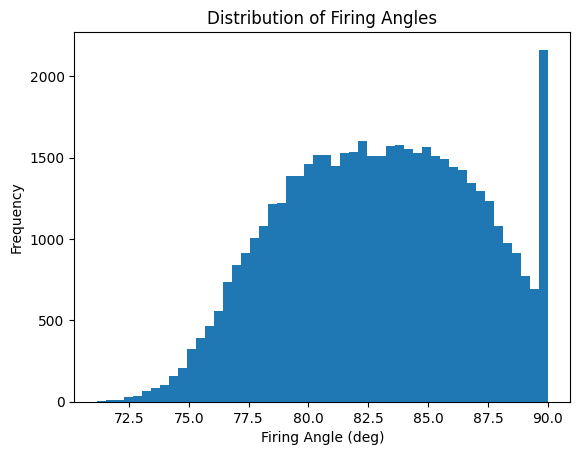

In [31]:
df.fillna(df.mean(), inplace=True)  # Filling missing values with the mean
from sklearn.preprocessing import StandardScaler

# Assuming the features are distance, velocity, wind speed, and wind direction
scaler = StandardScaler()
df[['Distance_to_Target_m', 'Initial_Velocity_m_s', 'Wind_Speed_m_s', 'Wind_Direction_deg']] = scaler.fit_transform(
    df[['Distance_to_Target_m', 'Initial_Velocity_m_s', 'Wind_Speed_m_s', 'Wind_Direction_deg']])
    
import matplotlib.pyplot as plt

plt.hist(df['Firing_Angle_deg'], bins=50)
plt.title('Distribution of Firing Angles')
plt.xlabel('Firing Angle (deg)')
plt.ylabel('Frequency')
plt.show()
